In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm

In [2]:
SEED = 1097
rng = np.random.default_rng(SEED)
az.style.use("arviz-darkgrid")

In [3]:
alpha, sigma = 3, 0.5
beta = -1.5

size = 100

X = np.random.randn(size)

Y = alpha + beta * X + rng.normal(size=size) * sigma

Text(0.5, 0, 'X')

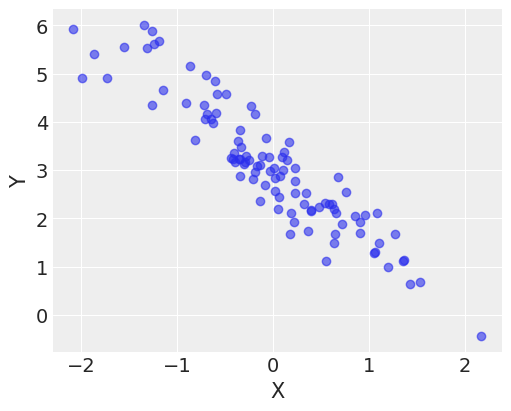

In [4]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(5,4))
axes.scatter(X, Y, alpha=0.6)
axes.set_ylabel('Y')
axes.set_xlabel('X')

In [5]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    f = alpha + beta * X
    obs = pm.Normal("obs", mu=f, sigma=sigma, observed=Y)

In [6]:
with basic_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

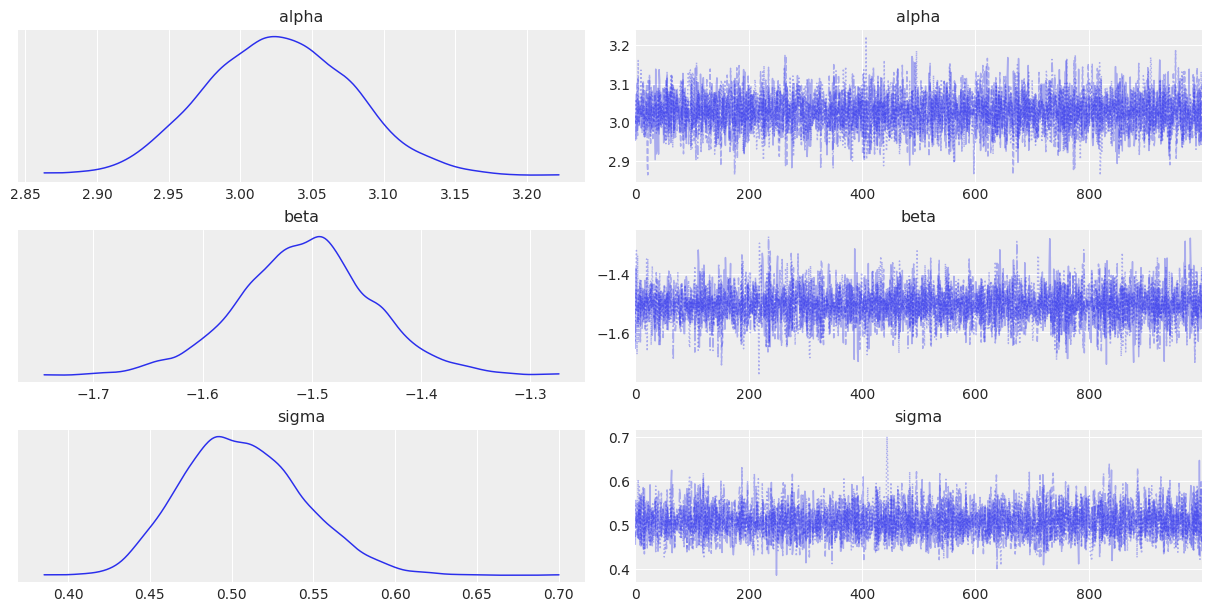

In [7]:
az.plot_trace(idata, combined=True)

In [8]:
back_model = pm.Model()

with back_model:
    x = pm.Normal("x", mu=0, sigma=1)

    f = 2.975 + (-1.525) * x
    y = pm.Normal("y", mu=f, sigma=0.45, observed=[6])

In [9]:
with back_model:
    bdata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

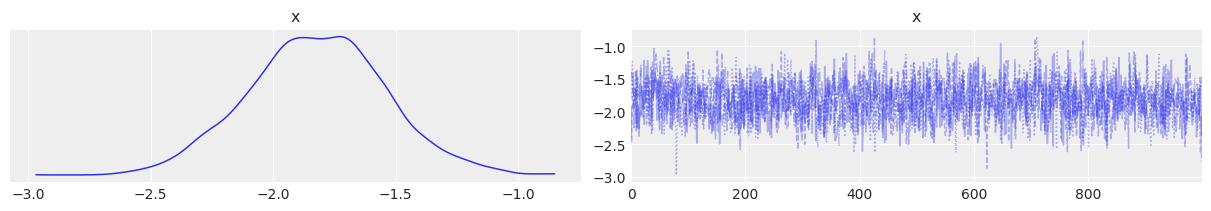

In [10]:
az.plot_trace(bdata, combined=True)

# GP example

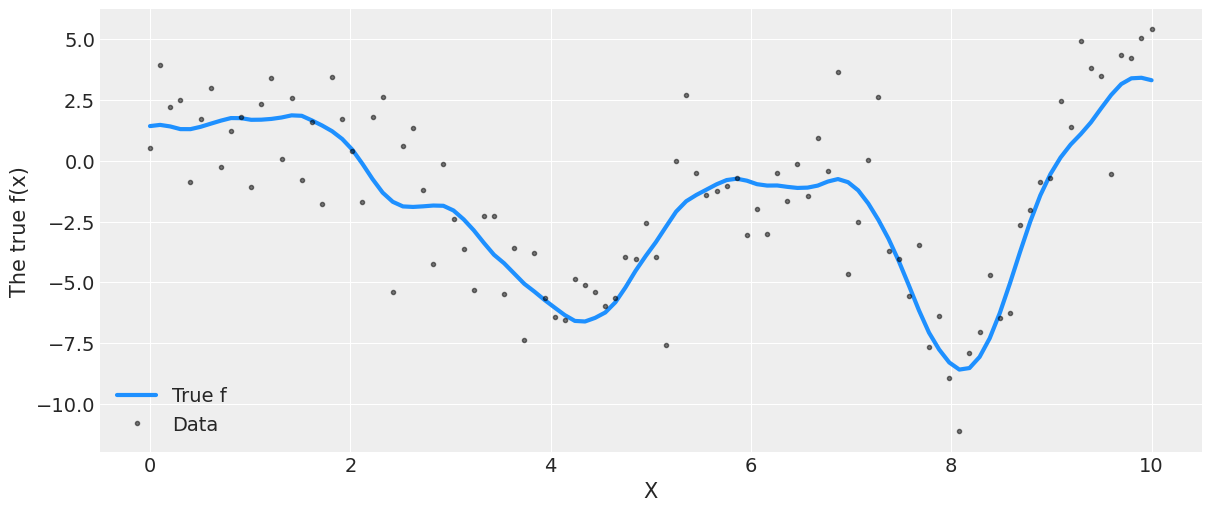

In [11]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend()

In [12]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.Matern52(1, ell)
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, sigma=sigma)

    with model:
        marginal_post = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 40 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [13]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

with model:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=["f_pred"]
    )

Sampling: [f_pred]


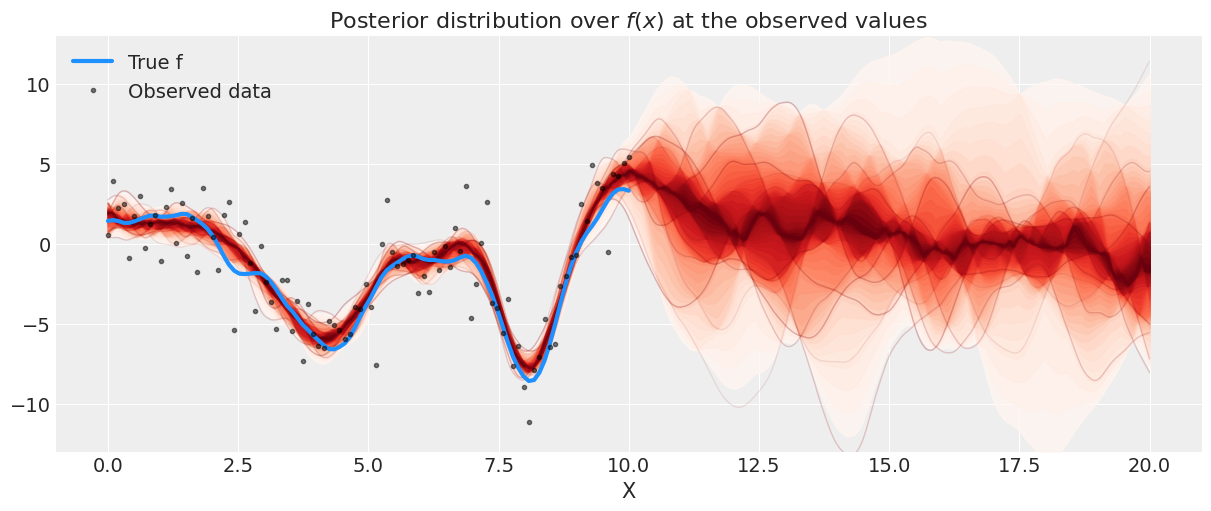

In [14]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_new)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

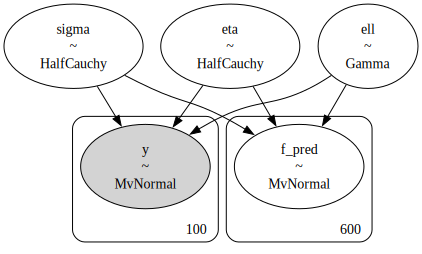

In [15]:
pm.model_to_graphviz(model)